# Extraksi Kata Kunci dengan BERT Untuk Meningkatkan Pemahaman Abstrak Artikel Ilmiah
---
Pada penelitian ini, dilakukan ekstraksi kata kunci dari abstrak paper ilmiah yang berkaitan dengan teknologi menggunakan dua model pre-trained, yaitu BERT (Bidirectional Encoder Representations from Transformers) dan DistilBERT. Proses ekstraksi kata kunci bertujuan untuk memahami dan mengekstraksi informasi penting dari teks yang berkaitan dengan penelitian ilmiah di bidang teknologi.


## IMPORT dan INSTALL

In [ ]:
!pip install lightning
!pip install keyphrase-vectorizers
!pip install datasets
!pip install textacy
!pip install spacy
!pip install -U accelerate
!pip install -U transformers
!pip install spacy
!pip install textacy

In [ ]:
import ast
import torch
import numpy as np
import pandas as pd
import re
import os
import time
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    EarlyStoppingCallback
)
import textacy
from textacy.extract.keyterms import scake
from keyphrase_vectorizers import KeyphraseCountVectorizer
from datasets import Dataset
import torch.nn as nn
from sklearn.model_selection import train_test_split

## LOAD DATA

In [ ]:
# Membaca dataset
data = pd.read_excel('/content/DataAbstrak.xlsx')

## SPLITING DATA

In [ ]:
# Membaca dataset
data = pd.read_excel('/content/DataAbstrak.xlsx')

# Acak data
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

def split_data(data, test_size, random_state=42):
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state)
    return train_data, test_data

train_80, test_20 = split_data(data_shuffled, test_size=0.2)
train_70, test_30 = split_data(data_shuffled, test_size=0.3)


# Menampilkan hasil
print("80:20 Split")
print("Train Data (80%):", len(train_80))
print("Test Data (20%):", len(test_20))
print("\n70:30 Split")
print("Train Data (70%):", len(train_70))
print("Test Data (30%):", len(test_30))


## PRA PEMROSESAN

### BIO Tagging dengan NLTK

Masing masing dataset ditambahkan dengan B-I-O

In [ ]:
#data_path = "test_30.xlsx"
data_path = "train_60.xlsx"
#data_path = "test_20.xlsx"
#data_path = "train_80.xlsx"
df = pd.read_excel(data_path)

# Tokenization function
def split_pertanyaan_into_words(text):
    if isinstance(text, str):
        tokens = nltk.word_tokenize(text)  # Tokenize
        return tokens
    else:
        return []

df['tokenized_text'] = df['Abstrak'].apply(split_pertanyaan_into_words)


# Export the DataFrame with the tokenized words to a new Excel file
#df.to_excel('test_30_.xlsx', index=False)
df.to_excel('train_70_.xlsx', index=False)
#df.to_excel('test_20_.xlsx', index=False)
#df.to_excel('train_80_.xlsx', index=False)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def label_tokens_with_bio(tokens, keywords):
    clean_tokens = [re.sub(r'[^\w\s]$', '', token).lower() for token in tokens]
    labels = ["O"] * len(tokens)
    keyword_list = [re.sub(r'[^\w\s]', '', keyword.strip().lower()) for keyword in keywords.split(",")]

    for keyword in keyword_list:
        keyword_tokens = keyword.split()
        keyword_len = len(keyword_tokens)

        start_idx = 0
        while start_idx <= len(clean_tokens) - keyword_len:
            if clean_tokens[start_idx:start_idx + keyword_len] == keyword_tokens:
                labels[start_idx] = "B-KEYWORD"
                for j in range(1, keyword_len):
                    labels[start_idx + j] = "I-KEYWORD"
                start_idx += keyword_len
                break
            else:
                start_idx += 1

    return labels


def process_dataset(input_file, output_file):
    df = pd.read_excel(input_file)
    df['keyword'] = df['keyword'].str.replace(';', ',', regex=False)

    df['keyword'] = df['keyword'].str.title()
    df['keyword'] = df['keyword'].str.rstrip(',')

    df = df.dropna(subset=['keyword'])
    df = df[df['keyword'] != '']

    bio_labels = []
    for idx, row in df.iterrows():
        start_time = time.time()
        labels = label_tokens_with_bio(eval(row['tokenized_text']), row['keyword'])
        bio_labels.append(labels)
        print(f"Row {idx} processing time: {time.time() - start_time:.2f} seconds")

    df['bio_tags'] = bio_labels

    if os.path.exists(output_file):
        existing_df = pd.read_excel(output_file)
        combined_df = pd.concat([existing_df, df], ignore_index=True)
    else:
        combined_df = df

    combined_df.to_excel(output_file, index=False)


# Example usage
#input_file = 'test_30_.xlsx'  # Replace with the path to your dataset
#output_file = 'test_30_t.xlsx'
input_file = 'train_60_.xlsx'
output_file = 'train_60_t.xlsx'
#input_file = 'test_20_.xlsx'  # Replace with the path to your dataset
#output_file = 'test_20_t.xlsx'
#input_file = 'train_70_.xlsx'  # Replace with the path to your dataset
#output_file = 'train_70_t.xlsx'

# Process dataset and save the result
start_time = time.time()
process_dataset(input_file, output_file)  # Adjust to specify the range
print(f"Processing time: {time.time() - start_time:.2f} seconds")

print("Dataset with BIO labels has been processed and appended to the spreadsheet.")

Row 0 processing time: 0.00 seconds
Row 1 processing time: 0.00 seconds
Row 2 processing time: 0.00 seconds
Row 3 processing time: 0.00 seconds
Row 4 processing time: 0.00 seconds
Row 5 processing time: 0.00 seconds
Row 6 processing time: 0.00 seconds
Row 7 processing time: 0.00 seconds
Row 8 processing time: 0.00 seconds
Row 9 processing time: 0.00 seconds
Row 10 processing time: 0.00 seconds
Row 11 processing time: 0.00 seconds
Row 12 processing time: 0.00 seconds
Row 13 processing time: 0.00 seconds
Row 14 processing time: 0.00 seconds
Row 15 processing time: 0.00 seconds
Row 16 processing time: 0.00 seconds
Row 17 processing time: 0.00 seconds
Row 18 processing time: 0.00 seconds
Row 19 processing time: 0.00 seconds
Row 20 processing time: 0.00 seconds
Row 21 processing time: 0.00 seconds
Row 22 processing time: 0.00 seconds
Row 23 processing time: 0.00 seconds
Row 24 processing time: 0.00 seconds
Row 25 processing time: 0.00 seconds
Row 26 processing time: 0.00 seconds
Row 27 proc

### BIO Tagging dengan BERT

In [ ]:
#data_path = "test_30.xlsx"
data_path = "train_60.xlsx"
#data_path = "test_20.xlsx"
#data_path = "train_80.xlsx"
df = pd.read_excel(data_path)
# Drop rows where 'keyword' is NaN
df = df.dropna(subset=['keyword'])

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Function to generate BIO labels and tokenized text
def create_bio_tags_and_tokenized_text(text, keywords):
    # Tokenize the full text
    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(text)))
    bio_tags = ['O'] * len(tokens)  # Start with all 'O' tags

    # Process each keyword individually
    for keyword in keywords:
        # Tokenize the keyword and find its positions in the text
        keyword_tokens = tokenizer.tokenize(keyword.lower())
        for i in range(len(tokens) - len(keyword_tokens) + 1):
            # Check if the keyword matches the sequence in text tokens
            if tokens[i:i + len(keyword_tokens)] == keyword_tokens:
                bio_tags[i] = 'B-KEYWORD'  # Start of the keyword
                for j in range(1, len(keyword_tokens)):
                    bio_tags[i + j] = 'I-KEYWORD'  # Inside the keyword

    return tokens, bio_tags

# Apply function for each row in the DataFrame
tokenized_texts = []
bio_labels = []
for index, row in df.iterrows():
    abstrak_text = row['Abstrak']
    # Split keywords by comma or semicolon
    keywords = [kw.strip() for kw in re.split(r'[;,]', row['keyword']) if kw.strip()]
    tokens, bio_tags = create_bio_tags_and_tokenized_text(abstrak_text, keywords)
    tokenized_texts.append(tokens)
    bio_labels.append(bio_tags)

# Add tokenized abstracts and BIO tags to the DataFrame
df['tokenized_text'] = tokenized_texts
df['bio_tags'] = bio_labels

# Save the DataFrame with tokenized text and BIO tags to the specified Excel file
output_file_path = 'test_20_t.xlsx'
df.to_excel(output_file_path, index=False)

output_file_path

## Skenario 1 NLTK 7030 (BERT)

### Inisialisasi Data

In [ ]:
train_data = pd.read_excel('train_70_t.xlsx')
test_data = pd.read_excel('test_30_t.xlsx')

#### Ubah tipe data menjadi list

In [ ]:
train_data['tokenized_text'] = train_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
train_data['bio_tags'] = train_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test_data['bio_tags'] = test_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
print(type(train_data.iloc[0]["tokenized_text"]))
print(type(train_data.iloc[0]["bio_tags"]))

<class 'list'>
<class 'list'>


In [ ]:
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

### Inisialisasi Model

In [ ]:
logging.getLogger("transformers").setLevel(logging.ERROR)

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
batch_size = 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Penyesuailan label dan Token

In [ ]:
label_list = np.unique([item for sublist in train_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
label_list = np.unique([item for sublist in test_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
def encode_labels(labels, max_length=512):
    encoded_labels = [label_dict[label] for label in labels]
    encoded_labels = encoded_labels[:max_length] + [-100] * (max_length - len(encoded_labels))
    return encoded_labels

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokenized_text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        is_split_into_words=True,
        return_tensors="pt",
    )

    encoded_labels = []
    for i, label in enumerate(examples["bio_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Mendapatkan word IDs
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)  # Padding
            elif word_idx != previous_word_idx:
                labels.append(label_dict[label[word_idx]])  # Label kata baru
            else:
                labels.append(
                    label_dict[
                        label[word_idx]
                        if label[word_idx].startswith("I")
                        else "I-KEYWORD"  # Menangani subtokens
                    ]
                )
            previous_word_idx = word_idx
        # Pastikan panjang labels sesuai dengan input_ids
        labels = labels[:512] + [-100] * (512 - len(labels))
        encoded_labels.append(labels)

    tokenized_inputs["labels"] = torch.tensor(encoded_labels)
    return tokenized_inputs


In [ ]:
# Tokenisasi untuk train dan test set
tokenized_train_data = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/3774 [00:00<?, ? examples/s]

Map:   0%|          | 0/1618 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

### Training Argumen

In [ ]:
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    logging_dir="./output/logs",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(predictions_and_labels):
    predictions, labels = predictions_and_labels
    predictions = np.argmax(predictions, axis=-1)

    true_predictions = [p for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]
    true_labels = [l for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]

    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(true_labels, true_predictions, average=None)

    # Calculate macro averages
    precision_macro = precision_per_class.mean()
    recall_macro = recall_per_class.mean()
    f1_macro = f1_score(true_labels, true_predictions, average="macro")

    # Calculate micro averages for overall metrics
    accuracy = accuracy_score(true_labels, true_predictions)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(true_labels, true_predictions, average="micro")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions)

    # Return metrics per class, macro, micro, and confusion matrix
    return {
        "precision_per_class": precision_per_class.tolist(),
        "recall_per_class": recall_per_class.tolist(),
        "f1_per_class": f1_per_class.tolist(),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "accuracy": accuracy,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro,
        "confusion_matrix": conf_matrix.tolist()  # Convert to list for easy display
    }

In [ ]:
print("Label List:", label_list)


Label List: ['B-KEYWORD' 'I-KEYWORD' 'O']


### Train Eval (learning rate 2)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list)).to('cuda')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))
trainer.train()

<ipython-input-28-612988e4a02a>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.0883, 'grad_norm': 0.4684041738510132, 'learning_rate': 1.7500000000000002e-05, 'epoch': 1.0}
{'eval_loss': 0.06859447807073593, 'eval_precision_per_class': [0.5424710424710425, 0.9917545408092163, 0.9768660058181303], 'eval_recall_per_class': [0.07323429762835548, 0.9216672422724917, 0.9980646180582985], 'eval_f1_per_class': [0.12904707233065443, 0.9554272672350138, 0.9873515405592413], 'eval_precision_macro': 0.837030529699463, 'eval_recall_macro': 0.6643220526530486, 'eval_f1_macro': 0.6906086267083031, 'eval_accuracy': 0.978041194301389, 'eval_precision_micro': 0.978041194301389, 'eval_recall_micro': 0.978041194301389, 'eval_f1_micro': 0.978041194301389, 'eval_confusion_matrix': [[281, 4, 3552], [0, 42699, 3629], [237, 351, 303228]], 'eval_runtime': 49.1045, 'eval_samples_per_second': 32.95, 'eval_steps_per_second': 4.134, 'epoch': 1.0}
{'loss': 0.0649, 'grad_norm': 0.49595367908477783, 'learning_rate': 1.5000000000000002e-05, 'epoch': 2.0}
{'eval_loss': 0.06733921170234

TrainOutput(global_step=6608, training_loss=0.04938399993767172, metrics={'train_runtime': 3133.2103, 'train_samples_per_second': 9.636, 'train_steps_per_second': 2.41, 'train_loss': 0.04938399993767172, 'epoch': 7.0})

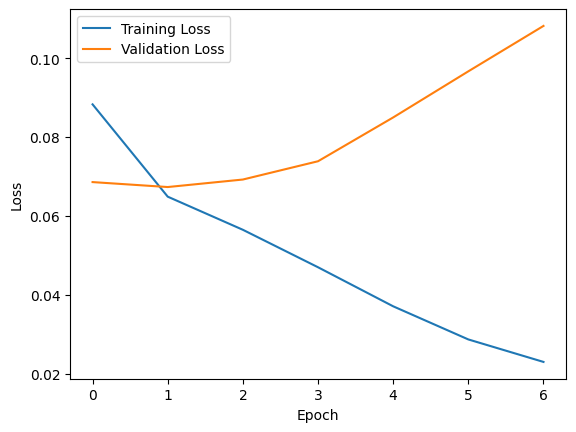

In [ ]:
loss = []
val_loss = []
for d in trainer.state.log_history:
    if "loss" in d:
        loss.append(d["loss"])
    if "eval_loss" in d:
        val_loss.append(d["eval_loss"])

plt.plot(loss)
plt.plot(val_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

{'eval_loss': 0.07387875020503998, 'eval_precision_per_class': [0.38813857897827364, 0.9606725500121042, 0.9832828640343978], 'eval_recall_per_class': [0.3445400052124055, 0.9422379554481092, 0.987554967480317], 'eval_f1_per_class': [0.36504210962308437, 0.9513659594407575, 0.9854142855266097], 'eval_precision_macro': 0.7773646643415919, 'eval_recall_macro': 0.758110976046944, 'eval_f1_macro': 0.7672741181968172, 'eval_accuracy': 0.9746540068534751, 'eval_precision_micro': 0.9746540068534751, 'eval_recall_micro': 0.9746540068534751, 'eval_f1_micro': 0.9746540068534751, 'eval_confusion_matrix': [[1322, 67, 2448], [23, 43652, 2653], [2061, 1720, 300035]], 'eval_runtime': 49.6728, 'eval_samples_per_second': 32.573, 'eval_steps_per_second': 4.087, 'epoch': 7.0}


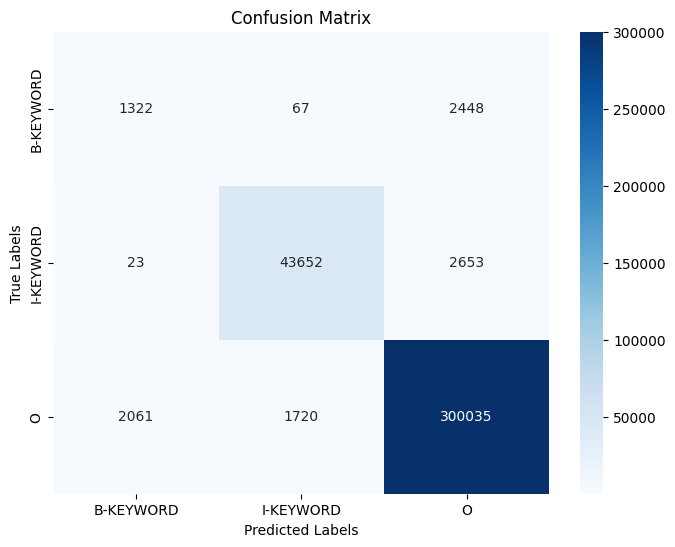

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluasi model untuk mendapatkan metrics termasuk confusion matrix
eval_results = trainer.evaluate()
conf_matrix = np.array(eval_results["eval_confusion_matrix"])

# Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


### Saved Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_pretrained("/content/drive/MyDrive/model_bert70302/")
tokenizer.save_pretrained("/content/drive/MyDrive/model_ber70302/")

('/content/drive/MyDrive/model_ber70302/tokenizer_config.json',
 '/content/drive/MyDrive/model_ber70302/special_tokens_map.json',
 '/content/drive/MyDrive/model_ber70302/vocab.txt',
 '/content/drive/MyDrive/model_ber70302/added_tokens.json',
 '/content/drive/MyDrive/model_ber70302/tokenizer.json')

## Skenario 2 NLTK 7030 (DistilBERT)

### Inisialisasi Data

In [ ]:
train_data = pd.read_excel('train_70_t.xlsx')
test_data = pd.read_excel('test_30_t.xlsx')

#### Ubah tipe data menjadi list

In [ ]:
train_data['tokenized_text'] = train_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
train_data['bio_tags'] = train_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test_data['bio_tags'] = test_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)



In [ ]:
print(type(train_data.iloc[0]["tokenized_text"]))
print(type(train_data.iloc[0]["bio_tags"]))


<class 'list'>
<class 'list'>


In [ ]:
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

### Inisialisasi Model

In [ ]:
logging.getLogger("transformers").setLevel(logging.ERROR)

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
batch_size = 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Penyesuailan label dan Token

In [ ]:
label_list = np.unique([item for sublist in train_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
label_list = np.unique([item for sublist in test_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
def encode_labels(labels, max_length=512):
    encoded_labels = [label_dict[label] for label in labels]
    encoded_labels = encoded_labels[:max_length] + [-100] * (max_length - len(encoded_labels))
    return encoded_labels

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokenized_text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        is_split_into_words=True,
        return_tensors="pt",
    )

    encoded_labels = []
    for i, label in enumerate(examples["bio_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Mendapatkan word IDs
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)  # Padding
            elif word_idx != previous_word_idx:
                labels.append(label_dict[label[word_idx]])  # Label kata baru
            else:
                labels.append(
                    label_dict[
                        label[word_idx]
                        if label[word_idx].startswith("I")
                        else "I-KEYWORD"  # Menangani subtokens
                    ]
                )
            previous_word_idx = word_idx
        # Pastikan panjang labels sesuai dengan input_ids
        labels = labels[:512] + [-100] * (512 - len(labels))
        encoded_labels.append(labels)

    tokenized_inputs["labels"] = torch.tensor(encoded_labels)
    return tokenized_inputs


In [ ]:
# Tokenisasi untuk train dan test set
tokenized_train_data = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/7548 [00:00<?, ? examples/s]

Map:   0%|          | 0/3236 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

### Training Argumen

In [ ]:
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    logging_dir="./output/logs",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(predictions_and_labels):
    predictions, labels = predictions_and_labels
    predictions = np.argmax(predictions, axis=-1)

    true_predictions = [p for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]
    true_labels = [l for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]

    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(true_labels, true_predictions, average=None)

    # Calculate macro averages
    precision_macro = precision_per_class.mean()
    recall_macro = recall_per_class.mean()
    f1_macro = f1_score(true_labels, true_predictions, average="macro")

    # Calculate micro averages for overall metrics
    accuracy = accuracy_score(true_labels, true_predictions)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(true_labels, true_predictions, average="micro")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions)

    # Return metrics per class, macro, micro, and confusion matrix
    return {
        "precision_per_class": precision_per_class.tolist(),
        "recall_per_class": recall_per_class.tolist(),
        "f1_per_class": f1_per_class.tolist(),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "accuracy": accuracy,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro,
        "confusion_matrix": conf_matrix.tolist()  # Convert to list for easy display
    }

In [ ]:
print("Label List:", label_list)


Label List: ['B-KEYWORD' 'I-KEYWORD' 'O']


### Train Eval (learning rate 2)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list)).to('cuda')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))
trainer.train()

<ipython-input-20-612988e4a02a>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.0784, 'grad_norm': 0.453830361366272, 'learning_rate': 1.7500000000000002e-05, 'epoch': 1.0}
{'eval_loss': 0.06806748360395432, 'eval_precision_per_class': [0.5053763440860215, 0.9788804128845326, 0.9796302597255302], 'eval_recall_per_class': [0.15923898879332812, 0.9334311863236056, 0.9950397609079179], 'eval_f1_per_class': [0.24217201743955608, 0.9556157118391249, 0.9872748856568546], 'eval_precision_macro': 0.821295672232028, 'eval_recall_macro': 0.6959033120082839, 'eval_f1_macro': 0.7283542049785119, 'eval_accuracy': 0.9779168938445849, 'eval_precision_micro': 0.9779168938445849, 'eval_recall_micro': 0.9779168938445849, 'eval_f1_micro': 0.9779168938445849, 'eval_confusion_matrix': [[1222, 44, 6408], [4, 86488, 6164], [1192, 1822, 604618]], 'eval_runtime': 53.5124, 'eval_samples_per_second': 60.472, 'eval_steps_per_second': 7.568, 'epoch': 1.0}
{'loss': 0.0546, 'grad_norm': 0.6730684638023376, 'learning_rate': 1.5000000000000002e-05, 'epoch': 2.0}
{'eval_loss': 0.0754922

TrainOutput(global_step=9435, training_loss=0.04134581221685121, metrics={'train_runtime': 2337.0336, 'train_samples_per_second': 25.838, 'train_steps_per_second': 6.459, 'train_loss': 0.04134581221685121, 'epoch': 5.0})

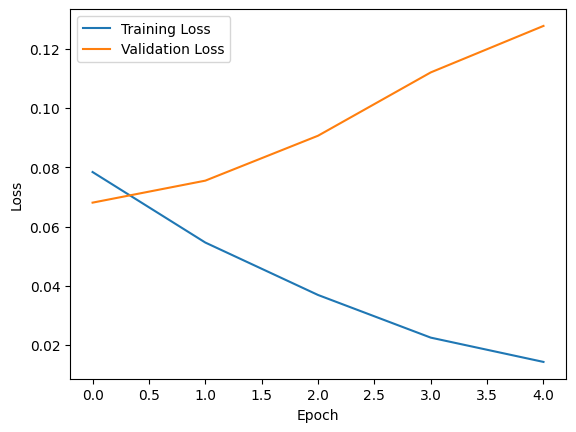

In [ ]:
loss = []
val_loss = []
for d in trainer.state.log_history:
    if "loss" in d:
        loss.append(d["loss"])
    if "eval_loss" in d:
        val_loss.append(d["eval_loss"])

plt.plot(loss)
plt.plot(val_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

{'eval_loss': 0.07549220323562622, 'eval_precision_per_class': [0.38728866624921726, 0.9541763719877223, 0.9836247334754797], 'eval_recall_per_class': [0.3223872817305186, 0.946123294767743, 0.9869723780182742], 'eval_f1_per_class': [0.35187028872137677, 0.9501327697393378, 0.9852957122625545], 'eval_precision_macro': 0.7750299239041398, 'eval_recall_macro': 0.7518276515055119, 'eval_f1_macro': 0.762432923574423, 'eval_accuracy': 0.9744223560021583, 'eval_precision_micro': 0.9744223560021583, 'eval_recall_micro': 0.9744223560021583, 'eval_f1_micro': 0.9744223560021583, 'eval_confusion_matrix': [[2474, 150, 5050], [58, 87664, 4934], [3856, 4060, 599716]], 'eval_runtime': 46.7514, 'eval_samples_per_second': 69.217, 'eval_steps_per_second': 8.663, 'epoch': 5.0}


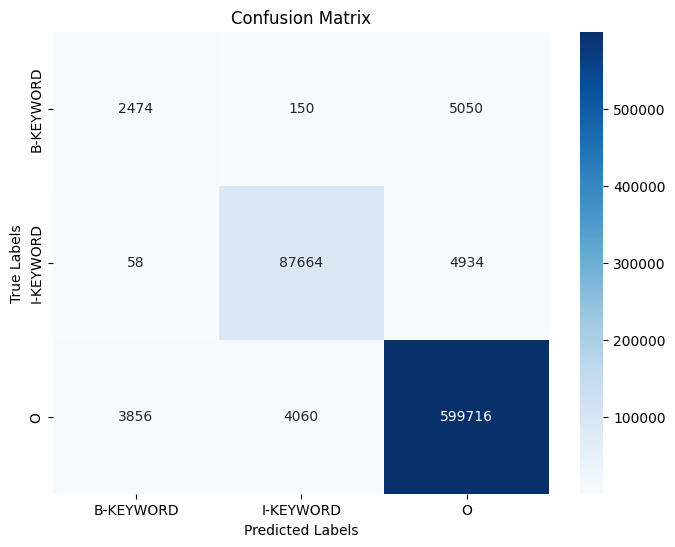

In [ ]:


# Evaluasi model untuk mendapatkan metrics termasuk confusion matrix
eval_results = trainer.evaluate()
conf_matrix = np.array(eval_results["eval_confusion_matrix"])

# Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


### Saved Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_pretrained("/content/drive/MyDrive/model_distilbert70302/")
tokenizer.save_pretrained("/content/drive/MyDrive/model_distilber70302/")

('/content/drive/MyDrive/model_distilber70302/tokenizer_config.json',
 '/content/drive/MyDrive/model_distilber70302/special_tokens_map.json',
 '/content/drive/MyDrive/model_distilber70302/vocab.txt',
 '/content/drive/MyDrive/model_distilber70302/added_tokens.json',
 '/content/drive/MyDrive/model_distilber70302/tokenizer.json')

## Skenario 3 NLTK 8020 (BERT)

### Inisialisasi Data

In [ ]:
train_data = pd.read_excel('train_80_t.xlsx')
test_data = pd.read_excel('test_20_t.xlsx')

#### Ubah Tipe data menjadi list

In [ ]:
train_data['tokenized_text'] = train_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
train_data['bio_tags'] = train_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test_data['bio_tags'] = test_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
print(type(train_data.iloc[0]["tokenized_text"]))
print(type(train_data.iloc[0]["bio_tags"]))

<class 'list'>
<class 'list'>


In [ ]:
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

### Inisialisasi Model

In [ ]:
logging.getLogger("transformers").setLevel(logging.ERROR)

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
batch_size = 8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Penyesuaian Label dan Token

In [ ]:
label_list = np.unique([item for sublist in train_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
label_list = np.unique([item for sublist in test_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
def encode_labels(labels, max_length=512):
    encoded_labels = [label_dict[label] for label in labels]
    encoded_labels = encoded_labels[:max_length] + [-100] * (max_length - len(encoded_labels))
    return encoded_labels

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokenized_text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        is_split_into_words=True,
        return_tensors="pt",
    )

    encoded_labels = []
    for i, label in enumerate(examples["bio_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Mendapatkan word IDs
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)  # Padding
            elif word_idx != previous_word_idx:
                labels.append(label_dict[label[word_idx]])  # Label kata baru
            else:
                labels.append(
                    label_dict[
                        label[word_idx]
                        if label[word_idx].startswith("I")
                        else "I-KEYWORD"  # Menangani subtokens
                    ]
                )
            previous_word_idx = word_idx
        # Pastikan panjang labels sesuai dengan input_ids
        labels = labels[:512] + [-100] * (512 - len(labels))
        encoded_labels.append(labels)

    tokenized_inputs["labels"] = torch.tensor(encoded_labels)
    return tokenized_inputs


In [ ]:
# Tokenisasi untuk train dan test set
tokenized_train_data = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/4313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1079 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

### Training Argumen

In [ ]:
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    logging_dir="./output/logs",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    report_to="none"  # Disable logging to W&B
)
# Data collator for padding


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(predictions_and_labels):
    predictions, labels = predictions_and_labels
    predictions = np.argmax(predictions, axis=-1)

    true_predictions = [p for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]
    true_labels = [l for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]

    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(true_labels, true_predictions, average=None)

    # Calculate macro averages
    precision_macro = precision_per_class.mean()
    recall_macro = recall_per_class.mean()
    f1_macro = f1_score(true_labels, true_predictions, average="macro")

    # Calculate micro averages for overall metrics
    accuracy = accuracy_score(true_labels, true_predictions)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(true_labels, true_predictions, average="micro")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions)

    # Return metrics per class, macro, micro, and confusion matrix
    return {
        "precision_per_class": precision_per_class.tolist(),
        "recall_per_class": recall_per_class.tolist(),
        "f1_per_class": f1_per_class.tolist(),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "accuracy": accuracy,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro,
        "confusion_matrix": conf_matrix.tolist()  # Convert to list for easy display
    }

In [ ]:
print("Label List:", label_list)


Label List: ['B-KEYWORD' 'I-KEYWORD' 'O']


### Train Eval (learning rate 2)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list)).to('cuda')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<ipython-input-20-612988e4a02a>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.0873, 'grad_norm': 1.792083978652954, 'learning_rate': 1.7500000000000002e-05, 'epoch': 1.0}
{'eval_loss': 0.06942317634820938, 'eval_precision_per_class': [0.5399239543726235, 0.9887413592498803, 0.9765267276859165], 'eval_recall_per_class': [0.054447852760736194, 0.9229516051748922, 0.9978454757455788], 'eval_f1_per_class': [0.09892023685127134, 0.9547144249673699, 0.9870710046185435], 'eval_precision_macro': 0.8350640137694735, 'eval_recall_macro': 0.6584149778937357, 'eval_f1_macro': 0.6802352221457282, 'eval_accuracy': 0.9775493997685244, 'eval_precision_micro': 0.9775493997685244, 'eval_recall_micro': 0.9775493997685244, 'eval_f1_micro': 0.9775493997685244, 'eval_confusion_matrix': [[142, 13, 2453], [0, 28893, 2412], [121, 316, 202392]], 'eval_runtime': 31.1408, 'eval_samples_per_second': 34.649, 'eval_steps_per_second': 4.335, 'epoch': 1.0}
{'loss': 0.0639, 'grad_norm': 0.8686912655830383, 'learning_rate': 1.5000000000000002e-05, 'epoch': 2.0}
{'eval_loss': 0.06812345

TrainOutput(global_step=8632, training_loss=0.04516475812719308, metrics={'train_runtime': 4013.4348, 'train_samples_per_second': 8.597, 'train_steps_per_second': 2.151, 'train_loss': 0.04516475812719308, 'epoch': 8.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.11699444055557251, 'eval_precision_per_class': [0.35852156057494866, 0.9479133277774217, 0.9833783830357099], 'eval_recall_per_class': [0.33473926380368096, 0.9446733748602459, 0.9847359105453363], 'eval_f1_per_class': [0.34622248661511007, 0.9462905780522535, 0.9840566786060926], 'eval_precision_macro': 0.7632710904626934, 'eval_recall_macro': 0.7547161830697543, 'eval_f1_macro': 0.758856581091152, 'eval_accuracy': 0.9722778383218863, 'eval_precision_micro': 0.9722778383218863, 'eval_recall_micro': 0.9722778383218863, 'eval_f1_micro': 0.9722778383218863, 'eval_confusion_matrix': [[873, 60, 1675], [31, 29573, 1701], [1531, 1565, 199733]], 'eval_runtime': 28.6882, 'eval_samples_per_second': 37.611, 'eval_steps_per_second': 4.706, 'epoch': 8.0}


{'eval_loss': 0.11699444055557251,
 'eval_precision_per_class': [0.35852156057494866,
  0.9479133277774217,
  0.9833783830357099],
 'eval_recall_per_class': [0.33473926380368096,
  0.9446733748602459,
  0.9847359105453363],
 'eval_f1_per_class': [0.34622248661511007,
  0.9462905780522535,
  0.9840566786060926],
 'eval_precision_macro': 0.7632710904626934,
 'eval_recall_macro': 0.7547161830697543,
 'eval_f1_macro': 0.758856581091152,
 'eval_accuracy': 0.9722778383218863,
 'eval_precision_micro': 0.9722778383218863,
 'eval_recall_micro': 0.9722778383218863,
 'eval_f1_micro': 0.9722778383218863,
 'eval_confusion_matrix': [[873, 60, 1675],
  [31, 29573, 1701],
  [1531, 1565, 199733]],
 'eval_runtime': 28.6882,
 'eval_samples_per_second': 37.611,
 'eval_steps_per_second': 4.706,
 'epoch': 8.0}

In [ ]:
model.save_pretrained("./best_model")
tokenizer.save_pretrained("./best_model")

('./best_model/tokenizer_config.json',
 './best_model/special_tokens_map.json',
 './best_model/vocab.txt',
 './best_model/added_tokens.json',
 './best_model/tokenizer.json')

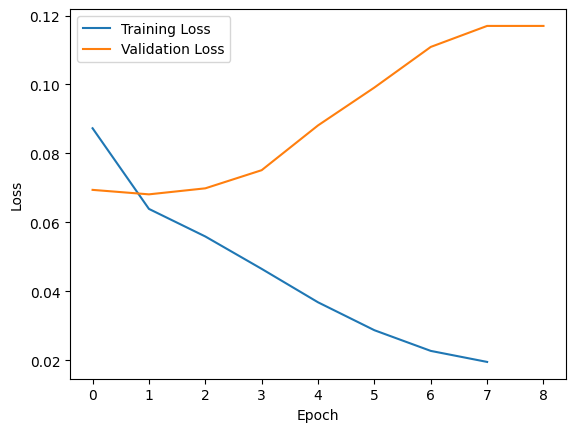

In [ ]:
loss = []
val_loss = []
for d in trainer.state.log_history:
    if "loss" in d:
        loss.append(d["loss"])
    if "eval_loss" in d:
        val_loss.append(d["eval_loss"])

plt.plot(loss)
plt.plot(val_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

{'eval_loss': 0.11699444055557251, 'eval_precision_per_class': [0.35852156057494866, 0.9479133277774217, 0.9833783830357099], 'eval_recall_per_class': [0.33473926380368096, 0.9446733748602459, 0.9847359105453363], 'eval_f1_per_class': [0.34622248661511007, 0.9462905780522535, 0.9840566786060926], 'eval_precision_macro': 0.7632710904626934, 'eval_recall_macro': 0.7547161830697543, 'eval_f1_macro': 0.758856581091152, 'eval_accuracy': 0.9722778383218863, 'eval_precision_micro': 0.9722778383218863, 'eval_recall_micro': 0.9722778383218863, 'eval_f1_micro': 0.9722778383218863, 'eval_confusion_matrix': [[873, 60, 1675], [31, 29573, 1701], [1531, 1565, 199733]], 'eval_runtime': 29.3534, 'eval_samples_per_second': 36.759, 'eval_steps_per_second': 4.599, 'epoch': 8.0}


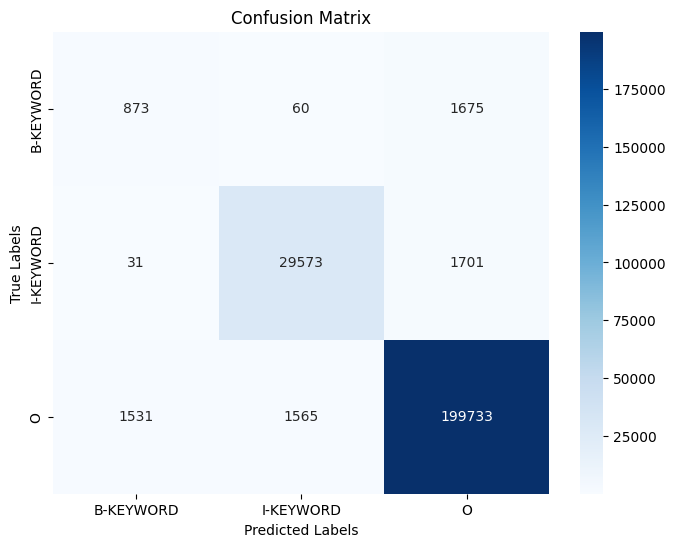

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluasi model untuk mendapatkan metrics termasuk confusion matrix
eval_results = trainer.evaluate()
conf_matrix = np.array(eval_results["eval_confusion_matrix"])

# Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


### Saved Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_pretrained("/content/drive/MyDrive/model_bert80202/")
tokenizer.save_pretrained("/content/drive/MyDrive/model_bert80202/")

('/content/drive/MyDrive/model_bert80202/tokenizer_config.json',
 '/content/drive/MyDrive/model_bert80202/special_tokens_map.json',
 '/content/drive/MyDrive/model_bert80202/vocab.txt',
 '/content/drive/MyDrive/model_bert80202/added_tokens.json',
 '/content/drive/MyDrive/model_bert80202/tokenizer.json')

## Skenario 4 NLTK 8020 (DistilBERT)

### Inisialisasi Data

In [ ]:
train_data = pd.read_excel('train_80_t.xlsx')
test_data = pd.read_excel('test_20_t.xlsx')

#### Ubah Tipe data menjadi list

In [ ]:
train_data['tokenized_text'] = train_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
train_data['bio_tags'] = train_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test_data['bio_tags'] = test_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)



In [ ]:
print(type(train_data.iloc[0]["tokenized_text"]))
print(type(train_data.iloc[0]["bio_tags"]))


<class 'list'>
<class 'list'>


In [ ]:
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

### Inisialisasi Model

In [ ]:
logging.getLogger("transformers").setLevel(logging.ERROR)

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
batch_size = 8


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Penyesuaian Label dan Token

In [ ]:
label_list = np.unique([item for sublist in train_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
label_list = np.unique([item for sublist in test_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
def encode_labels(labels, max_length=512):
    encoded_labels = [label_dict[label] for label in labels]
    encoded_labels = encoded_labels[:max_length] + [-100] * (max_length - len(encoded_labels))
    return encoded_labels

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokenized_text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        is_split_into_words=True,
        return_tensors="pt",
    )

    encoded_labels = []
    for i, label in enumerate(examples["bio_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            elif word_idx != previous_word_idx:
                labels.append(label_dict[label[word_idx]])
            else:
                labels.append(
                    label_dict[
                        label[word_idx]
                        if label[word_idx].startswith("I")
                        else "I-KEYWORD"
                    ]
                )
            previous_word_idx = word_idx
        labels = labels[:512] + [-100] * (512 - len(labels))
        encoded_labels.append(labels)

    tokenized_inputs["labels"] = torch.tensor(encoded_labels)
    return tokenized_inputs


In [ ]:

tokenized_train_data = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/4313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1079 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

### Training Argumen

In [ ]:
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    logging_dir="./output/logs",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    report_to="none"
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(predictions_and_labels):
    predictions, labels = predictions_and_labels
    predictions = np.argmax(predictions, axis=-1)

    true_predictions = [p for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]
    true_labels = [l for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]

    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(true_labels, true_predictions, average=None)

    # Calculate macro averages
    precision_macro = precision_per_class.mean()
    recall_macro = recall_per_class.mean()
    f1_macro = f1_score(true_labels, true_predictions, average="macro")

    # Calculate micro averages for overall metrics
    accuracy = accuracy_score(true_labels, true_predictions)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(true_labels, true_predictions, average="micro")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions)

    # Return metrics per class, macro, micro, and confusion matrix
    return {
        "precision_per_class": precision_per_class.tolist(),
        "recall_per_class": recall_per_class.tolist(),
        "f1_per_class": f1_per_class.tolist(),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "accuracy": accuracy,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro,
        "confusion_matrix": conf_matrix.tolist()  # Convert to list for easy display
    }

In [ ]:
print("Label List:", label_list)


Label List: ['B-KEYWORD' 'I-KEYWORD' 'O']


### Train dan Eval

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list)).to('cuda')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<ipython-input-49-612988e4a02a>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.0876, 'grad_norm': 1.7235500812530518, 'learning_rate': 1.7500000000000002e-05, 'epoch': 1.0}
{'eval_loss': 0.06988212466239929, 'eval_precision_per_class': [0.5362776025236593, 0.9881620364034488, 0.9765633672302205], 'eval_recall_per_class': [0.0651840490797546, 0.9226002236064527, 0.9975940324115388], 'eval_f1_per_class': [0.11623931623931624, 0.9542563560372028, 0.9869666801617458], 'eval_precision_macro': 0.8336676687191096, 'eval_recall_macro': 0.6617927683659154, 'eval_f1_macro': 0.6858207841460883, 'eval_accuracy': 0.977405783511164, 'eval_precision_micro': 0.977405783511164, 'eval_recall_micro': 0.977405783511164, 'eval_f1_micro': 0.977405783511164, 'eval_confusion_matrix': [[170, 5, 2433], [0, 28882, 2423], [147, 341, 202341]], 'eval_runtime': 33.8079, 'eval_samples_per_second': 31.916, 'eval_steps_per_second': 3.993, 'epoch': 1.0}
{'loss': 0.0642, 'grad_norm': 1.0476890802383423, 'learning_rate': 1.5000000000000002e-05, 'epoch': 2.0}
{'eval_loss': 0.06834142655134

TrainOutput(global_step=8632, training_loss=0.04514127312378269, metrics={'train_runtime': 4019.7595, 'train_samples_per_second': 8.584, 'train_steps_per_second': 2.147, 'train_loss': 0.04514127312378269, 'epoch': 8.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.10152407735586166, 'eval_precision_per_class': [0.36457473162675474, 0.9414377260326121, 0.9839495458535094], 'eval_recall_per_class': [0.33857361963190186, 0.9479635840919981, 0.9837991608695009], 'eval_f1_per_class': [0.3510934393638171, 0.9446893851369634, 0.983874347614927], 'eval_precision_macro': 0.7633206678376254, 'eval_recall_macro': 0.7567787881978004, 'eval_f1_macro': 0.7598857240385692, 'eval_accuracy': 0.9719525897390409, 'eval_precision_micro': 0.9719525897390409, 'eval_recall_micro': 0.9719525897390409, 'eval_f1_micro': 0.9719525897390409, 'eval_confusion_matrix': [[883, 66, 1659], [33, 29676, 1596], [1506, 1780, 199543]], 'eval_runtime': 33.7315, 'eval_samples_per_second': 31.988, 'eval_steps_per_second': 4.002, 'epoch': 8.0}


{'eval_loss': 0.10152407735586166,
 'eval_precision_per_class': [0.36457473162675474,
  0.9414377260326121,
  0.9839495458535094],
 'eval_recall_per_class': [0.33857361963190186,
  0.9479635840919981,
  0.9837991608695009],
 'eval_f1_per_class': [0.3510934393638171,
  0.9446893851369634,
  0.983874347614927],
 'eval_precision_macro': 0.7633206678376254,
 'eval_recall_macro': 0.7567787881978004,
 'eval_f1_macro': 0.7598857240385692,
 'eval_accuracy': 0.9719525897390409,
 'eval_precision_micro': 0.9719525897390409,
 'eval_recall_micro': 0.9719525897390409,
 'eval_f1_micro': 0.9719525897390409,
 'eval_confusion_matrix': [[883, 66, 1659],
  [33, 29676, 1596],
  [1506, 1780, 199543]],
 'eval_runtime': 33.7315,
 'eval_samples_per_second': 31.988,
 'eval_steps_per_second': 4.002,
 'epoch': 8.0}

In [ ]:
model.save_pretrained("./best_model")
tokenizer.save_pretrained("./best_model")


('./best_model/tokenizer_config.json',
 './best_model/special_tokens_map.json',
 './best_model/vocab.txt',
 './best_model/added_tokens.json',
 './best_model/tokenizer.json')

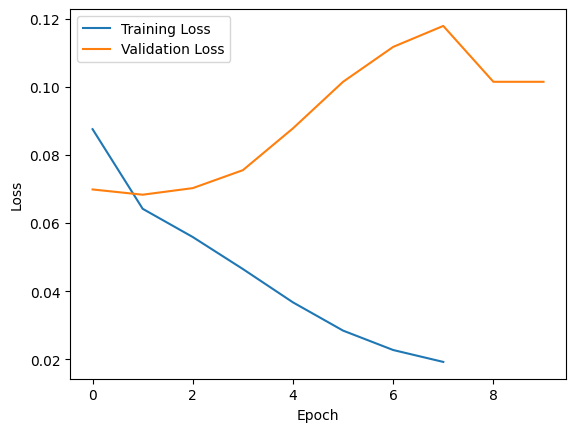

In [ ]:
loss = []
val_loss = []
for d in trainer.state.log_history:
    if "loss" in d:
        loss.append(d["loss"])
    if "eval_loss" in d:
        val_loss.append(d["eval_loss"])

plt.plot(loss)
plt.plot(val_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

{'eval_loss': 0.10152407735586166, 'eval_precision_per_class': [0.36457473162675474, 0.9414377260326121, 0.9839495458535094], 'eval_recall_per_class': [0.33857361963190186, 0.9479635840919981, 0.9837991608695009], 'eval_f1_per_class': [0.3510934393638171, 0.9446893851369634, 0.983874347614927], 'eval_precision_macro': 0.7633206678376254, 'eval_recall_macro': 0.7567787881978004, 'eval_f1_macro': 0.7598857240385692, 'eval_accuracy': 0.9719525897390409, 'eval_precision_micro': 0.9719525897390409, 'eval_recall_micro': 0.9719525897390409, 'eval_f1_micro': 0.9719525897390409, 'eval_confusion_matrix': [[883, 66, 1659], [33, 29676, 1596], [1506, 1780, 199543]], 'eval_runtime': 36.7682, 'eval_samples_per_second': 29.346, 'eval_steps_per_second': 3.672, 'epoch': 8.0}


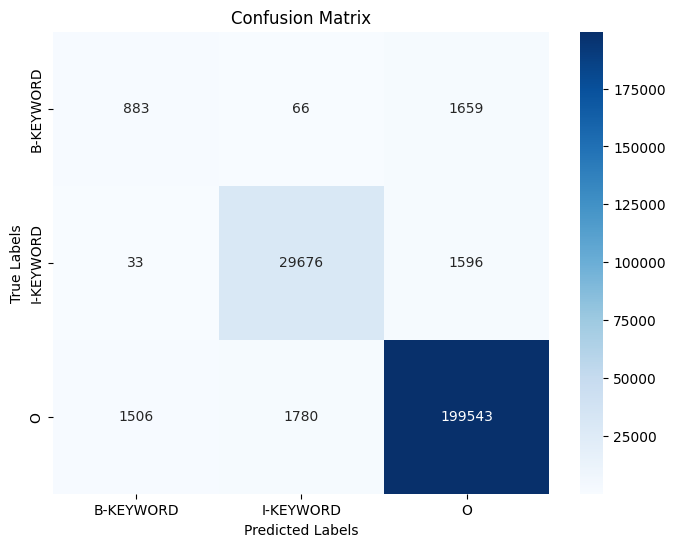

In [ ]:

# Evaluasi model untuk mendapatkan metrics termasuk confusion matrix
eval_results = trainer.evaluate()
conf_matrix = np.array(eval_results["eval_confusion_matrix"])

# Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


### Saved model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save_pretrained("/content/drive/MyDrive/model_distilbert80202/")
tokenizer.save_pretrained("/content/drive/MyDrive/model_distilbert80202/")

('/content/drive/MyDrive/model_distilbert80202/tokenizer_config.json',
 '/content/drive/MyDrive/model_distilbert80202/special_tokens_map.json',
 '/content/drive/MyDrive/model_distilbert80202/vocab.txt',
 '/content/drive/MyDrive/model_distilbert80202/added_tokens.json',
 '/content/drive/MyDrive/model_distilbert80202/tokenizer.json')

## Skenario 5 BERT 7030 (BERT)

### Inisialisasi Data

In [ ]:
train_data = pd.read_excel('train_70_t2.xlsx')
test_data = pd.read_excel('test_30_t2.xlsx')

#### Ubah Tipe data menjadi list

In [ ]:
train_data['tokenized_text'] = train_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
train_data['bio_tags'] = train_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test_data['bio_tags'] = test_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
print(type(train_data.iloc[0]["tokenized_text"]))
print(type(train_data.iloc[0]["bio_tags"]))


<class 'list'>
<class 'list'>


In [ ]:
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

### Inisialisasi Model

In [ ]:
logging.getLogger("transformers").setLevel(logging.ERROR)

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
batch_size = 8


### Penyesuaian Label dan Token

In [ ]:
label_list = np.unique([item for sublist in train_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
label_list = np.unique([item for sublist in test_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
def encode_labels(labels, max_length=512):
    encoded_labels = [label_dict[label] for label in labels]
    encoded_labels = encoded_labels[:max_length] + [-100] * (max_length - len(encoded_labels))
    return encoded_labels

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokenized_text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        is_split_into_words=True,
        return_tensors="pt",
    )

    encoded_labels = []
    for i, label in enumerate(examples["bio_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            elif word_idx != previous_word_idx:
                labels.append(label_dict[label[word_idx]])
            else:
                labels.append(
                    label_dict[
                        label[word_idx]
                        if label[word_idx].startswith("I")
                        else "I-KEYWORD"
                    ]
                )
            previous_word_idx = word_idx
        labels = labels[:512] + [-100] * (512 - len(labels))
        encoded_labels.append(labels)

    tokenized_inputs["labels"] = torch.tensor(encoded_labels)
    return tokenized_inputs


In [ ]:
tokenized_train_data = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/3774 [00:00<?, ? examples/s]

Map:   0%|          | 0/1618 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

### Training Argumen

In [ ]:
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    logging_dir="./output/logs",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(predictions_and_labels):
    predictions, labels = predictions_and_labels
    predictions = np.argmax(predictions, axis=-1)

    true_predictions = [p for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]
    true_labels = [l for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]

    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(true_labels, true_predictions, average=None)

    # Calculate macro averages
    precision_macro = precision_per_class.mean()
    recall_macro = recall_per_class.mean()
    f1_macro = f1_score(true_labels, true_predictions, average="macro")

    # Calculate micro averages for overall metrics
    accuracy = accuracy_score(true_labels, true_predictions)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(true_labels, true_predictions, average="micro")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions)

    # Return metrics per class, macro, micro, and confusion matrix
    return {
        "precision_per_class": precision_per_class.tolist(),
        "recall_per_class": recall_per_class.tolist(),
        "f1_per_class": f1_per_class.tolist(),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "accuracy": accuracy,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro,
        "confusion_matrix": conf_matrix.tolist()  # Convert to list for easy display
    }

In [ ]:
print("Label List:", label_list)


NameError: name 'label_list' is not defined

### Train dan Eval

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list)).to('cuda')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

<ipython-input-43-8e03926f5717>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.1344, 'grad_norm': 1.0308489799499512, 'learning_rate': 1.7500000000000002e-05, 'epoch': 1.0}
{'eval_loss': 0.11872953176498413, 'eval_precision_per_class': [0.5616113744075829, 0.9833390196747412, 0.9508223791912583], 'eval_recall_per_class': [0.17790566745902664, 0.8653639252383216, 0.9933905635570786], 'eval_f1_per_class': [0.27021377672209024, 0.920587178429311, 0.971640460095167], 'eval_precision_macro': 0.8319242577578608, 'eval_recall_macro': 0.6788867187514755, 'eval_f1_macro': 0.7208138050821895, 'eval_accuracy': 0.9538920051967282, 'eval_precision_micro': 0.9538920051967282, 'eval_recall_micro': 0.9538920051967282, 'eval_f1_micro': 0.9538920051967282, 'eval_confusion_matrix': [[1422, 44, 6527], [16, 69172, 10746], [1094, 1128, 333964]], 'eval_runtime': 50.631, 'eval_samples_per_second': 31.957, 'eval_steps_per_second': 4.009, 'epoch': 1.0}
{'loss': 0.109, 'grad_norm': 0.7313942909240723, 'learning_rate': 1.5000000000000002e-05, 'epoch': 2.0}
{'eval_loss': 0.1211958

TrainOutput(global_step=7552, training_loss=0.07445366453316252, metrics={'train_runtime': 3730.2264, 'train_samples_per_second': 8.094, 'train_steps_per_second': 2.025, 'train_loss': 0.07445366453316252, 'epoch': 8.0})

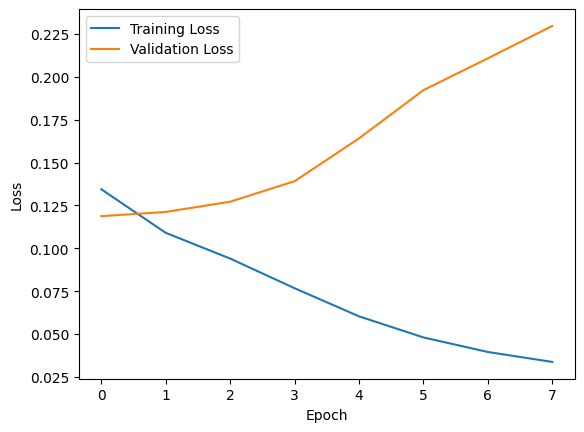

In [ ]:
loss = []
val_loss = []
for d in trainer.state.log_history:
    if "loss" in d:
        loss.append(d["loss"])
    if "eval_loss" in d:
        val_loss.append(d["eval_loss"])

plt.plot(loss)
plt.plot(val_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

{'eval_loss': 0.1391308605670929, 'eval_precision_per_class': [0.4263212705024733, 0.9038155508678435, 0.9670541017628397], 'eval_recall_per_class': [0.4097335168272238, 0.9165811794730653, 0.9647010880881417], 'eval_f1_per_class': [0.4178628389154705, 0.9101536053466834, 0.9658761618574232], 'eval_precision_macro': 0.7657303077110522, 'eval_recall_macro': 0.7636719281294768, 'eval_f1_macro': 0.7646308687065257, 'eval_accuracy': 0.9451726308790346, 'eval_precision_micro': 0.9451726308790346, 'eval_recall_micro': 0.9451726308790346, 'eval_f1_micro': 0.9451726308790346, 'eval_confusion_matrix': [[3275, 226, 4492], [111, 73266, 6557], [4296, 7571, 324319]], 'eval_runtime': 51.8294, 'eval_samples_per_second': 31.218, 'eval_steps_per_second': 3.917, 'epoch': 8.0}


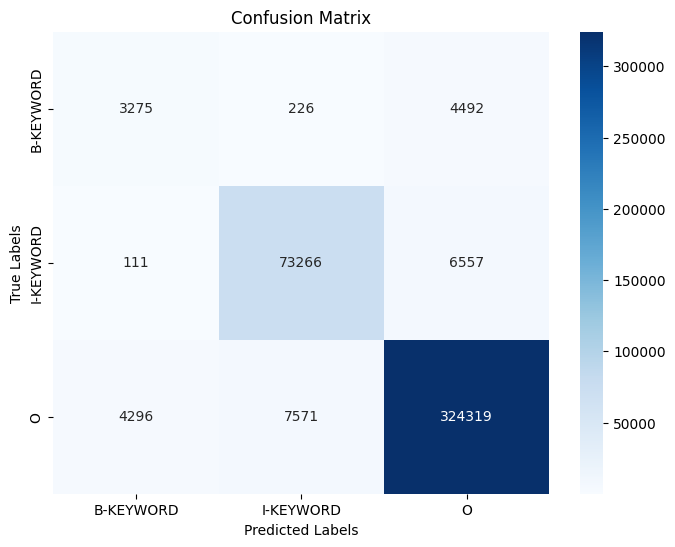

In [ ]:

# Evaluasi model untuk mendapatkan metrics termasuk confusion matrix
eval_results = trainer.evaluate()
conf_matrix = np.array(eval_results["eval_confusion_matrix"])

# Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


### Saved Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_pretrained("/content/drive/MyDrive/model_bert70302/")
tokenizer.save_pretrained("/content/drive/MyDrive/model_ber70302/")

('/content/drive/MyDrive/model_ber70302/tokenizer_config.json',
 '/content/drive/MyDrive/model_ber70302/special_tokens_map.json',
 '/content/drive/MyDrive/model_ber70302/vocab.txt',
 '/content/drive/MyDrive/model_ber70302/added_tokens.json',
 '/content/drive/MyDrive/model_ber70302/tokenizer.json')

## Skenario 6 BERT 8020 (DistilBERT)

### Insialisasi Data

In [ ]:
train_data = pd.read_excel('train_80_t2.xlsx')
test_data = pd.read_excel('test_20_t2.xlsx')

#### Ubah tipe data menjadi list

In [ ]:
train_data['tokenized_text'] = train_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
train_data['bio_tags'] = train_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test_data['bio_tags'] = test_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
print(type(train_data.iloc[0]["tokenized_text"]))
print(type(train_data.iloc[0]["bio_tags"]))


<class 'list'>
<class 'list'>


### Inisialisasi Model

In [ ]:
logging.getLogger("transformers").setLevel(logging.ERROR)

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
batch_size = 8

### Penyesuaian Label dan Token

In [ ]:
label_list = np.unique([item for sublist in train_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
label_list = np.unique([item for sublist in test_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
def encode_labels(labels, max_length=512):
    encoded_labels = [label_dict[label] for label in labels]
    encoded_labels = encoded_labels[:max_length] + [-100] * (max_length - len(encoded_labels))
    return encoded_labels

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokenized_text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        is_split_into_words=True,
        return_tensors="pt",
    )

    encoded_labels = []
    for i, label in enumerate(examples["bio_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Mendapatkan word IDs
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)  # Padding
            elif word_idx != previous_word_idx:
                labels.append(label_dict[label[word_idx]])  # Label kata baru
            else:
                labels.append(
                    label_dict[
                        label[word_idx]
                        if label[word_idx].startswith("I")
                        else "I-KEYWORD"  # Menangani subtokens
                    ]
                )
            previous_word_idx = word_idx
        # Pastikan panjang labels sesuai dengan input_ids
        labels = labels[:512] + [-100] * (512 - len(labels))
        encoded_labels.append(labels)

    tokenized_inputs["labels"] = torch.tensor(encoded_labels)
    return tokenized_inputs


In [ ]:
# Tokenisasi untuk train dan test set
tokenized_train_data = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/4311 [00:00<?, ? examples/s]

Map:   0%|          | 0/1079 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

### Training Argumen

In [ ]:
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    logging_dir="./output/logs",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    report_to="none"  # Disable logging to W&B
)
# Data collator for padding


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(predictions_and_labels):
    predictions, labels = predictions_and_labels
    predictions = np.argmax(predictions, axis=-1)

    true_predictions = [p for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]
    true_labels = [l for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]

    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(true_labels, true_predictions, average=None)

    # Calculate macro averages
    precision_macro = precision_per_class.mean()
    recall_macro = recall_per_class.mean()
    f1_macro = f1_score(true_labels, true_predictions, average="macro")

    # Calculate micro averages for overall metrics
    accuracy = accuracy_score(true_labels, true_predictions)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(true_labels, true_predictions, average="micro")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions)

    # Return metrics per class, macro, micro, and confusion matrix
    return {
        "precision_per_class": precision_per_class.tolist(),
        "recall_per_class": recall_per_class.tolist(),
        "f1_per_class": f1_per_class.tolist(),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "accuracy": accuracy,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro,
        "confusion_matrix": conf_matrix.tolist()  # Convert to list for easy display
    }

In [ ]:
print("Label List:", label_list)


Label List: ['B-KEYWORD' 'I-KEYWORD' 'O']


### Train dan Eval

In [ ]:

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list)).to('cuda')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))
trainer.train()

<ipython-input-51-612988e4a02a>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.1391, 'grad_norm': 0.7424350380897522, 'learning_rate': 1.7500000000000002e-05, 'epoch': 1.0}
{'eval_loss': 0.12240634858608246, 'eval_precision_per_class': [0.5608947804473903, 0.979392354625825, 0.9501289219065124], 'eval_recall_per_class': [0.1261177347242921, 0.8699170506912443, 0.9933452253326275], 'eval_f1_per_class': [0.20593155893536122, 0.9214143465188019, 0.9712565812794812], 'eval_precision_macro': 0.8301386856599092, 'eval_recall_macro': 0.663126670249388, 'eval_f1_macro': 0.6995341622445482, 'eval_accuracy': 0.9534348971060301, 'eval_precision_micro': 0.9534348971060301, 'eval_recall_micro': 0.9534348971060301, 'eval_f1_micro': 0.9534348971060301, 'eval_confusion_matrix': [[677, 22, 4669], [5, 47193, 7052], [525, 971, 223305]], 'eval_runtime': 17.3042, 'eval_samples_per_second': 62.355, 'eval_steps_per_second': 7.802, 'epoch': 1.0}
{'loss': 0.1113, 'grad_norm': 0.7056078910827637, 'learning_rate': 1.5000000000000002e-05, 'epoch': 2.0}
{'eval_loss': 0.11935523897

TrainOutput(global_step=7546, training_loss=0.08874685872368872, metrics={'train_runtime': 1851.5694, 'train_samples_per_second': 18.626, 'train_steps_per_second': 4.658, 'train_loss': 0.08874685872368872, 'epoch': 7.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.1381797194480896, 'eval_precision_per_class': [0.4331929980057611, 0.9292324029126213, 0.9627107452568561], 'eval_recall_per_class': [0.3641952309985097, 0.9032995391705069, 0.9728559926334848], 'eval_f1_per_class': [0.39570893634247545, 0.9160824780812443, 0.9677567808554088], 'eval_precision_macro': 0.7750453820584129, 'eval_recall_macro': 0.7467835876008339, 'eval_f1_macro': 0.7598493984263762, 'eval_accuracy': 0.948101216866665, 'eval_precision_micro': 0.948101216866665, 'eval_recall_micro': 0.948101216866665, 'eval_f1_micro': 0.948101216866665, 'eval_confusion_matrix': [[1955, 114, 3299], [74, 49004, 5172], [2484, 3618, 218699]], 'eval_runtime': 17.5844, 'eval_samples_per_second': 61.361, 'eval_steps_per_second': 7.677, 'epoch': 7.0}


{'eval_loss': 0.1381797194480896,
 'eval_precision_per_class': [0.4331929980057611,
  0.9292324029126213,
  0.9627107452568561],
 'eval_recall_per_class': [0.3641952309985097,
  0.9032995391705069,
  0.9728559926334848],
 'eval_f1_per_class': [0.39570893634247545,
  0.9160824780812443,
  0.9677567808554088],
 'eval_precision_macro': 0.7750453820584129,
 'eval_recall_macro': 0.7467835876008339,
 'eval_f1_macro': 0.7598493984263762,
 'eval_accuracy': 0.948101216866665,
 'eval_precision_micro': 0.948101216866665,
 'eval_recall_micro': 0.948101216866665,
 'eval_f1_micro': 0.948101216866665,
 'eval_confusion_matrix': [[1955, 114, 3299],
  [74, 49004, 5172],
  [2484, 3618, 218699]],
 'eval_runtime': 17.5844,
 'eval_samples_per_second': 61.361,
 'eval_steps_per_second': 7.677,
 'epoch': 7.0}

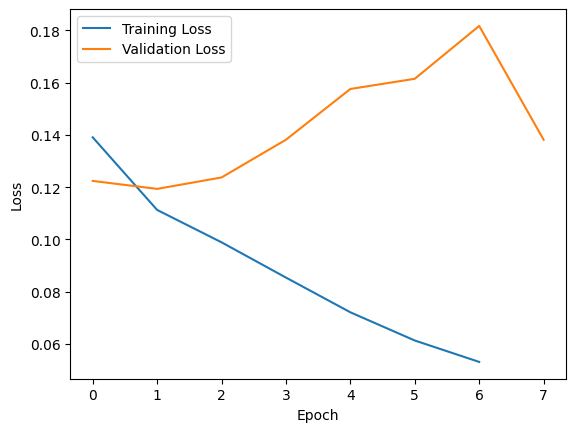

In [ ]:
loss = []
val_loss = []
for d in trainer.state.log_history:
    if "loss" in d:
        loss.append(d["loss"])
    if "eval_loss" in d:
        val_loss.append(d["eval_loss"])

plt.plot(loss)
plt.plot(val_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

{'eval_loss': 0.1381797194480896, 'eval_precision_per_class': [0.4331929980057611, 0.9292324029126213, 0.9627107452568561], 'eval_recall_per_class': [0.3641952309985097, 0.9032995391705069, 0.9728559926334848], 'eval_f1_per_class': [0.39570893634247545, 0.9160824780812443, 0.9677567808554088], 'eval_precision_macro': 0.7750453820584129, 'eval_recall_macro': 0.7467835876008339, 'eval_f1_macro': 0.7598493984263762, 'eval_accuracy': 0.948101216866665, 'eval_precision_micro': 0.948101216866665, 'eval_recall_micro': 0.948101216866665, 'eval_f1_micro': 0.948101216866665, 'eval_confusion_matrix': [[1955, 114, 3299], [74, 49004, 5172], [2484, 3618, 218699]], 'eval_runtime': 16.74, 'eval_samples_per_second': 64.456, 'eval_steps_per_second': 8.065, 'epoch': 7.0}


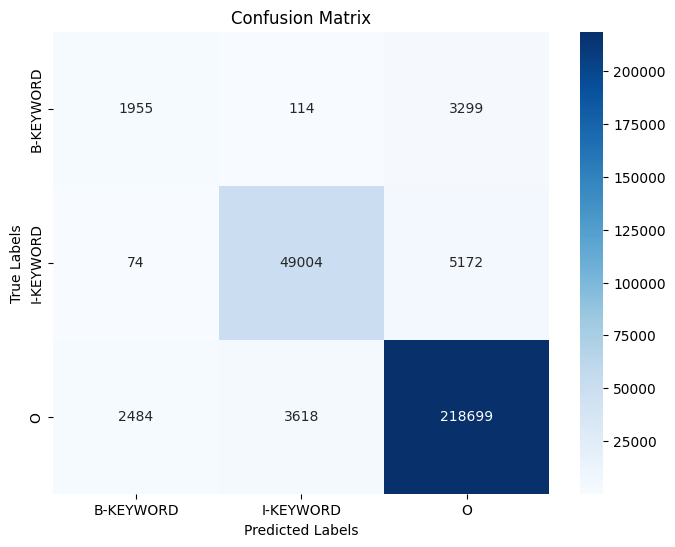

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluasi model untuk mendapatkan metrics termasuk confusion matrix
eval_results = trainer.evaluate()
conf_matrix = np.array(eval_results["eval_confusion_matrix"])

# Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


### Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save_pretrained("/content/drive/MyDrive/deeplearning/model_bert_distilbert8020")
tokenizer.save_pretrained("/content/drive/MyDrive/deeplearning/model_bert_distilbert8020")

('/content/drive/MyDrive/deeplearning/model_bert_distilbert8020/tokenizer_config.json',
 '/content/drive/MyDrive/deeplearning/model_bert_distilbert8020/special_tokens_map.json',
 '/content/drive/MyDrive/deeplearning/model_bert_distilbert8020/vocab.txt',
 '/content/drive/MyDrive/deeplearning/model_bert_distilbert8020/added_tokens.json',
 '/content/drive/MyDrive/deeplearning/model_bert_distilbert8020/tokenizer.json')

## Skenario 7 BERT 7030 (DistilBERT)

### Inisialisasi Data

In [ ]:
train_data = pd.read_excel('train_70_t2.xlsx')
test_data = pd.read_excel('test_30_t2.xlsx')

#### Ubah tipe data menjadi list

In [ ]:
train_data['tokenized_text'] = train_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
train_data['bio_tags'] = train_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test_data['bio_tags'] = test_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
print(type(train_data.iloc[0]["tokenized_text"]))
print(type(train_data.iloc[0]["bio_tags"]))


<class 'list'>
<class 'list'>


In [ ]:
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

### Inisialisasi Model

In [ ]:
logging.getLogger("transformers").setLevel(logging.ERROR)

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
batch_size = 8

### Penyesuaian Label dan Token

In [ ]:
label_list = np.unique([item for sublist in train_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
label_list = np.unique([item for sublist in test_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
def encode_labels(labels, max_length=512):
    encoded_labels = [label_dict[label] for label in labels]
    encoded_labels = encoded_labels[:max_length] + [-100] * (max_length - len(encoded_labels))
    return encoded_labels

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokenized_text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        is_split_into_words=True,
        return_tensors="pt",
    )

    encoded_labels = []
    for i, label in enumerate(examples["bio_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Mendapatkan word IDs
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)  # Padding
            elif word_idx != previous_word_idx:
                labels.append(label_dict[label[word_idx]])  # Label kata baru
            else:
                labels.append(
                    label_dict[
                        label[word_idx]
                        if label[word_idx].startswith("I")
                        else "I-KEYWORD"  # Menangani subtokens
                    ]
                )
            previous_word_idx = word_idx
        # Pastikan panjang labels sesuai dengan input_ids
        labels = labels[:512] + [-100] * (512 - len(labels))
        encoded_labels.append(labels)

    tokenized_inputs["labels"] = torch.tensor(encoded_labels)
    return tokenized_inputs


In [ ]:
# Tokenisasi untuk train dan test set
tokenized_train_data = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)

In [ ]:
# Tokenisasi untuk train dan test set
tokenized_train_data = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/3773 [00:00<?, ? examples/s]

Map:   0%|          | 0/1618 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

### Training Argumen

In [ ]:
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    logging_dir="./output/logs",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    report_to="none"  # Disable logging to W&B
)
# Data collator for padding


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(predictions_and_labels):
    predictions, labels = predictions_and_labels
    predictions = np.argmax(predictions, axis=-1)

    true_predictions = [p for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]
    true_labels = [l for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]

    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(true_labels, true_predictions, average=None)

    # Calculate macro averages
    precision_macro = precision_per_class.mean()
    recall_macro = recall_per_class.mean()
    f1_macro = f1_score(true_labels, true_predictions, average="macro")

    # Calculate micro averages for overall metrics
    accuracy = accuracy_score(true_labels, true_predictions)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(true_labels, true_predictions, average="micro")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions)

    # Return metrics per class, macro, micro, and confusion matrix
    return {
        "precision_per_class": precision_per_class.tolist(),
        "recall_per_class": recall_per_class.tolist(),
        "f1_per_class": f1_per_class.tolist(),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "accuracy": accuracy,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro,
        "confusion_matrix": conf_matrix.tolist()  # Convert to list for easy display
    }

In [ ]:
print("Label List:", label_list)


Label List: ['B-KEYWORD' 'I-KEYWORD' 'O']


### Train dan Eval

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list)).to('cuda')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))
trainer.train()

<ipython-input-92-612988e4a02a>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.141, 'grad_norm': 0.9376429319381714, 'learning_rate': 1.7500000000000002e-05, 'epoch': 1.0}
{'eval_loss': 0.12155602127313614, 'eval_precision_per_class': [0.5665094339622642, 0.9809391835522687, 0.9507618028194675], 'eval_recall_per_class': [0.15025647441511322, 0.8678784997623039, 0.993426258083323], 'eval_f1_per_class': [0.23751606842677742, 0.9209518436162092, 0.9716259029642538], 'eval_precision_macro': 0.8327368067780002, 'eval_recall_macro': 0.6705204107535799, 'eval_f1_macro': 0.7100312716690801, 'eval_accuracy': 0.9538731422993401, 'eval_precision_micro': 0.9538731422993401, 'eval_recall_micro': 0.9538731422993401, 'eval_f1_micro': 0.9538731422993401, 'eval_confusion_matrix': [[1201, 54, 6738], [3, 69373, 10558], [916, 1294, 333976]], 'eval_runtime': 27.2649, 'eval_samples_per_second': 59.344, 'eval_steps_per_second': 7.445, 'epoch': 1.0}
{'loss': 0.1117, 'grad_norm': 1.138266921043396, 'learning_rate': 1.5000000000000002e-05, 'epoch': 2.0}
{'eval_loss': 0.12207985

TrainOutput(global_step=7552, training_loss=0.08438315886562153, metrics={'train_runtime': 1950.1903, 'train_samples_per_second': 15.477, 'train_steps_per_second': 3.872, 'train_loss': 0.08438315886562153, 'epoch': 8.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.17365531623363495, 'eval_precision_per_class': [0.4107367362333417, 0.9066895710409042, 0.9660001488870692], 'eval_recall_per_class': [0.4087326410609283, 0.9112267620787149, 0.9649628479472673], 'eval_f1_per_class': [0.40973223803850256, 0.9089525045548706, 0.9654812198014616], 'eval_precision_macro': 0.7611421520537717, 'eval_recall_macro': 0.7616407503623036, 'eval_f1_macro': 0.7613886541316116, 'eval_accuracy': 0.944352094842648, 'eval_precision_micro': 0.944352094842648, 'eval_recall_micro': 0.944352094842648, 'eval_f1_micro': 0.944352094842648, 'eval_confusion_matrix': [[3267, 254, 4472], [150, 72838, 6946], [4537, 7242, 324407]], 'eval_runtime': 26.5665, 'eval_samples_per_second': 60.904, 'eval_steps_per_second': 7.641, 'epoch': 8.0}


{'eval_loss': 0.17365531623363495,
 'eval_precision_per_class': [0.4107367362333417,
  0.9066895710409042,
  0.9660001488870692],
 'eval_recall_per_class': [0.4087326410609283,
  0.9112267620787149,
  0.9649628479472673],
 'eval_f1_per_class': [0.40973223803850256,
  0.9089525045548706,
  0.9654812198014616],
 'eval_precision_macro': 0.7611421520537717,
 'eval_recall_macro': 0.7616407503623036,
 'eval_f1_macro': 0.7613886541316116,
 'eval_accuracy': 0.944352094842648,
 'eval_precision_micro': 0.944352094842648,
 'eval_recall_micro': 0.944352094842648,
 'eval_f1_micro': 0.944352094842648,
 'eval_confusion_matrix': [[3267, 254, 4472],
  [150, 72838, 6946],
  [4537, 7242, 324407]],
 'eval_runtime': 26.5665,
 'eval_samples_per_second': 60.904,
 'eval_steps_per_second': 7.641,
 'epoch': 8.0}

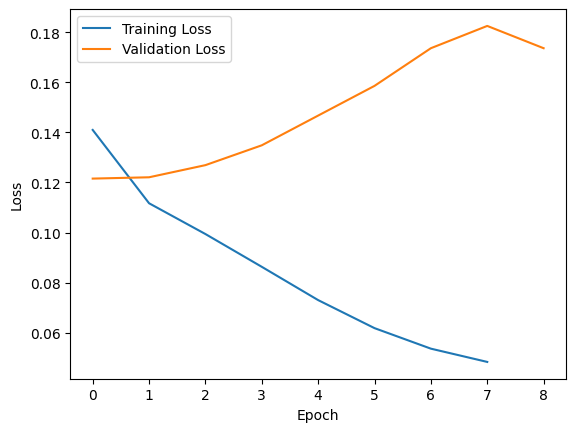

In [ ]:
loss = []
val_loss = []
for d in trainer.state.log_history:
    if "loss" in d:
        loss.append(d["loss"])
    if "eval_loss" in d:
        val_loss.append(d["eval_loss"])

plt.plot(loss)
plt.plot(val_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

{'eval_loss': 0.17365531623363495, 'eval_precision_per_class': [0.4107367362333417, 0.9066895710409042, 0.9660001488870692], 'eval_recall_per_class': [0.4087326410609283, 0.9112267620787149, 0.9649628479472673], 'eval_f1_per_class': [0.40973223803850256, 0.9089525045548706, 0.9654812198014616], 'eval_precision_macro': 0.7611421520537717, 'eval_recall_macro': 0.7616407503623036, 'eval_f1_macro': 0.7613886541316116, 'eval_accuracy': 0.944352094842648, 'eval_precision_micro': 0.944352094842648, 'eval_recall_micro': 0.944352094842648, 'eval_f1_micro': 0.944352094842648, 'eval_confusion_matrix': [[3267, 254, 4472], [150, 72838, 6946], [4537, 7242, 324407]], 'eval_runtime': 26.7826, 'eval_samples_per_second': 60.412, 'eval_steps_per_second': 7.58, 'epoch': 8.0}


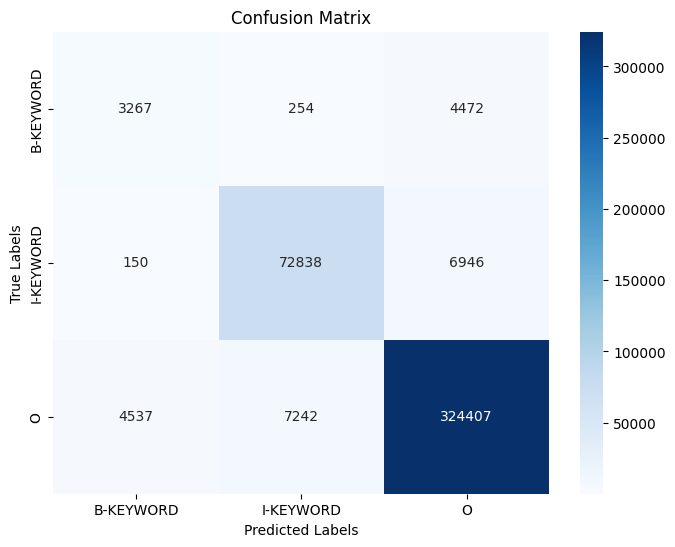

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluasi model untuk mendapatkan metrics termasuk confusion matrix
eval_results = trainer.evaluate()
conf_matrix = np.array(eval_results["eval_confusion_matrix"])

# Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


### Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save_pretrained("/content/drive/MyDrive/deeplearning/model_bert_distilbert7030")
tokenizer.save_pretrained("/content/drive/MyDrive/deeplearning/model_bert_distilbert7030/")

('/content/drive/MyDrive/deeplearning/model_bert_distilbert7030/tokenizer_config.json',
 '/content/drive/MyDrive/deeplearning/model_bert_distilbert7030/special_tokens_map.json',
 '/content/drive/MyDrive/deeplearning/model_bert_distilbert7030/vocab.txt',
 '/content/drive/MyDrive/deeplearning/model_bert_distilbert7030/added_tokens.json',
 '/content/drive/MyDrive/deeplearning/model_bert_distilbert7030/tokenizer.json')

## Skenario 8 BERT 8020 (BERT)

### Inisialisasi Data

In [ ]:
train_data = pd.read_excel('train_80_t2.xlsx')
test_data = pd.read_excel('test_20_t2.xlsx')

#### Ubah Tipe data menjadi list

In [ ]:
train_data['tokenized_text'] = train_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
train_data['bio_tags'] = train_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test_data['bio_tags'] = test_data['bio_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
print(type(train_data.iloc[0]["tokenized_text"]))
print(type(train_data.iloc[0]["bio_tags"]))


<class 'list'>
<class 'list'>


In [ ]:
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

### Inisialisasi Model

In [ ]:
logging.getLogger("transformers").setLevel(logging.ERROR)

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
batch_size = 8

### Penyesuaian Label dan Token

In [ ]:
label_list = np.unique([item for sublist in train_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
label_list = np.unique([item for sublist in test_dataset['bio_tags'] for item in sublist])
label_dict = {label: i for i, label in enumerate(label_list)}

In [ ]:
def encode_labels(labels, max_length=512):
    encoded_labels = [label_dict[label] for label in labels]
    encoded_labels = encoded_labels[:max_length] + [-100] * (max_length - len(encoded_labels))
    return encoded_labels

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokenized_text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        is_split_into_words=True,
        return_tensors="pt",
    )

    encoded_labels = []
    for i, label in enumerate(examples["bio_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            elif word_idx != previous_word_idx:
                labels.append(label_dict[label[word_idx]])
            else:
                labels.append(
                    label_dict[
                        label[word_idx]
                        if label[word_idx].startswith("I")
                        else "I-KEYWORD"
                    ]
                )
            previous_word_idx = word_idx
        labels = labels[:512] + [-100] * (512 - len(labels))
        encoded_labels.append(labels)

    tokenized_inputs["labels"] = torch.tensor(encoded_labels)
    return tokenized_inputs


In [ ]:
tokenized_train_data = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/4313 [00:00<?, ? examples/s]

Map:   0%|          | 0/1079 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

### Training Argumen

In [ ]:
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    logging_dir="./output/logs",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    report_to="none"
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(predictions_and_labels):
    predictions, labels = predictions_and_labels
    predictions = np.argmax(predictions, axis=-1)

    true_predictions = [p for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]
    true_labels = [l for pred, label in zip(predictions, labels) for (p, l) in zip(pred, label) if l != -100]

    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(true_labels, true_predictions, average=None)

    # Calculate macro averages
    precision_macro = precision_per_class.mean()
    recall_macro = recall_per_class.mean()
    f1_macro = f1_score(true_labels, true_predictions, average="macro")

    # Calculate micro averages for overall metrics
    accuracy = accuracy_score(true_labels, true_predictions)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(true_labels, true_predictions, average="micro")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions)

    # Return metrics per class, macro, micro, and confusion matrix
    return {
        "precision_per_class": precision_per_class.tolist(),
        "recall_per_class": recall_per_class.tolist(),
        "f1_per_class": f1_per_class.tolist(),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "accuracy": accuracy,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro,
        "confusion_matrix": conf_matrix.tolist()  # Convert to list for easy display
    }

In [ ]:
print("Label List:", label_list)


Label List: ['B-KEYWORD' 'I-KEYWORD' 'O']


### Train dan Eval

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list)).to('cuda')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<ipython-input-27-612988e4a02a>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.134, 'grad_norm': 1.2432003021240234, 'learning_rate': 1.7500000000000002e-05, 'epoch': 1.0}
{'eval_loss': 0.11877448111772537, 'eval_precision_per_class': [0.5341389728096677, 0.9831850273634959, 0.9505385499595556], 'eval_recall_per_class': [0.1646795827123696, 0.8676313364055299, 0.993198428832612], 'eval_f1_per_class': [0.2517442688309839, 0.9218009478672986, 0.9714003537158656], 'eval_precision_macro': 0.8226208500442397, 'eval_recall_macro': 0.6751697826501705, 'eval_f1_macro': 0.714981856804716, 'eval_accuracy': 0.953610694081619, 'eval_precision_micro': 0.953610694081619, 'eval_recall_micro': 0.953610694081619, 'eval_f1_micro': 0.953610694081619, 'eval_confusion_matrix': [[884, 40, 4444], [7, 47069, 7174], [764, 765, 223272]], 'eval_runtime': 31.0543, 'eval_samples_per_second': 34.746, 'eval_steps_per_second': 4.347, 'epoch': 1.0}
{'loss': 0.1086, 'grad_norm': 1.1268178224563599, 'learning_rate': 1.5000000000000002e-05, 'epoch': 2.0}
{'eval_loss': 0.11765453964471817

TrainOutput(global_step=6474, training_loss=0.08660371796304811, metrics={'train_runtime': 2890.5346, 'train_samples_per_second': 11.937, 'train_steps_per_second': 2.986, 'train_loss': 0.08660371796304811, 'epoch': 6.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.12667915225028992, 'eval_precision_per_class': [0.44658370509509276, 0.9378116131011736, 0.9622300580671193], 'eval_recall_per_class': [0.3543219076005961, 0.9014746543778802, 0.9759743061641185], 'eval_f1_per_class': [0.39513867248363976, 0.9192841970713735, 0.9690534503205518], 'eval_precision_macro': 0.7822084587544618, 'eval_recall_macro': 0.7439236227141982, 'eval_f1_macro': 0.761158773291855, 'eval_accuracy': 0.9500314676586304, 'eval_precision_micro': 0.9500314676586304, 'eval_recall_micro': 0.9500314676586304, 'eval_f1_micro': 0.9500314676586304, 'eval_confusion_matrix': [[1902, 142, 3324], [57, 48905, 5288], [2300, 3101, 219400]], 'eval_runtime': 30.4133, 'eval_samples_per_second': 35.478, 'eval_steps_per_second': 4.439, 'epoch': 6.0}


{'eval_loss': 0.12667915225028992,
 'eval_precision_per_class': [0.44658370509509276,
  0.9378116131011736,
  0.9622300580671193],
 'eval_recall_per_class': [0.3543219076005961,
  0.9014746543778802,
  0.9759743061641185],
 'eval_f1_per_class': [0.39513867248363976,
  0.9192841970713735,
  0.9690534503205518],
 'eval_precision_macro': 0.7822084587544618,
 'eval_recall_macro': 0.7439236227141982,
 'eval_f1_macro': 0.761158773291855,
 'eval_accuracy': 0.9500314676586304,
 'eval_precision_micro': 0.9500314676586304,
 'eval_recall_micro': 0.9500314676586304,
 'eval_f1_micro': 0.9500314676586304,
 'eval_confusion_matrix': [[1902, 142, 3324],
  [57, 48905, 5288],
  [2300, 3101, 219400]],
 'eval_runtime': 30.4133,
 'eval_samples_per_second': 35.478,
 'eval_steps_per_second': 4.439,
 'epoch': 6.0}

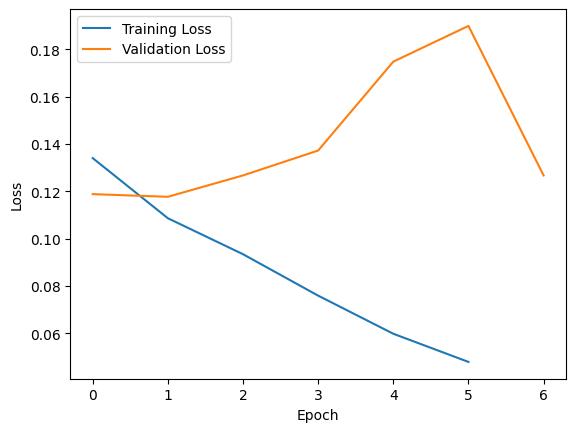

In [ ]:
loss = []
val_loss = []
for d in trainer.state.log_history:
    if "loss" in d:
        loss.append(d["loss"])
    if "eval_loss" in d:
        val_loss.append(d["eval_loss"])

plt.plot(loss)
plt.plot(val_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

{'eval_loss': 0.12667915225028992, 'eval_precision_per_class': [0.44658370509509276, 0.9378116131011736, 0.9622300580671193], 'eval_recall_per_class': [0.3543219076005961, 0.9014746543778802, 0.9759743061641185], 'eval_f1_per_class': [0.39513867248363976, 0.9192841970713735, 0.9690534503205518], 'eval_precision_macro': 0.7822084587544618, 'eval_recall_macro': 0.7439236227141982, 'eval_f1_macro': 0.761158773291855, 'eval_accuracy': 0.9500314676586304, 'eval_precision_micro': 0.9500314676586304, 'eval_recall_micro': 0.9500314676586304, 'eval_f1_micro': 0.9500314676586304, 'eval_confusion_matrix': [[1902, 142, 3324], [57, 48905, 5288], [2300, 3101, 219400]], 'eval_runtime': 30.522, 'eval_samples_per_second': 35.352, 'eval_steps_per_second': 4.423, 'epoch': 6.0}


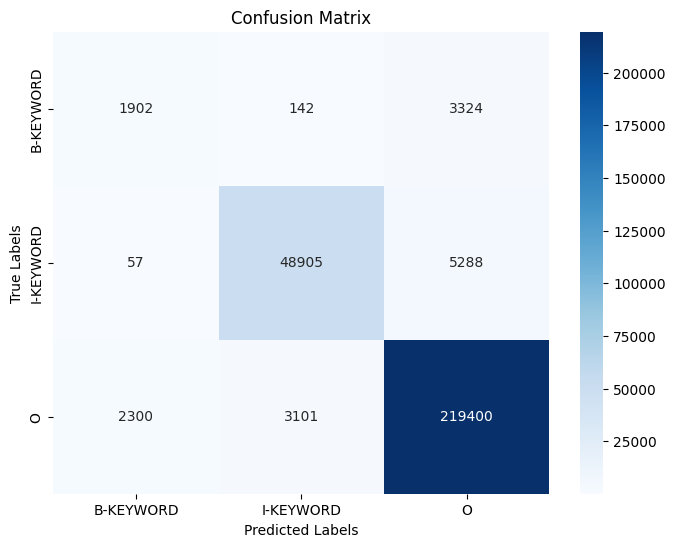

In [ ]:
# Evaluasi model untuk mendapatkan metrics termasuk confusion matrix
eval_results = trainer.evaluate()
conf_matrix = np.array(eval_results["eval_confusion_matrix"])

# Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_pretrained("/content/drive/MyDrive/model_bert80202/")
tokenizer.save_pretrained("/content/drive/MyDrive/model_bert80202/")

('/content/drive/MyDrive/model_bert80202/tokenizer_config.json',
 '/content/drive/MyDrive/model_bert80202/special_tokens_map.json',
 '/content/drive/MyDrive/model_bert80202/vocab.txt',
 '/content/drive/MyDrive/model_bert80202/added_tokens.json',
 '/content/drive/MyDrive/model_bert80202/tokenizer.json')

## Inference


In [ ]:
model_path = "/content/drive/MyDrive/model_distilbert80202/"
model = AutoModelForTokenClassification.from_pretrained(model_path).to("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_path)

### Load Model

In [ ]:
model_path = "/content/drive/MyDrive/model_bert70301/"
model = AutoModelForTokenClassification.from_pretrained(model_path).to("cpu")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/model_ber70301/")


### Load Dict

In [ ]:
#Load Dict
label_dict = {"B-KEYWORD": 0, "I-KEYWORD": 1, "O": 2}

### Test New Input

In [ ]:
import torch

# Input kalimat
new_sentence = " "
tokenized_input = tokenizer(
    new_sentence,
    padding="max_length",
    truncation=True,
    max_length=512,
    return_tensors="pt"
).to('cuda')

with torch.no_grad():
    outputs = model(**tokenized_input)
    logits = outputs.logits

predicted_ids = torch.argmax(logits, dim=-1).cpu().numpy()


tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'][0].cpu().numpy())
predicted_labels = [
    list(label_dict.keys())[list(label_dict.values()).index(id)] for id in predicted_ids[0] if id != -100
]

# Gabungkan tokens dengan label BIO
result = list(zip(tokens, predicted_labels))

# Ekstraksi keyword dan gabungkan sub-token dengan spasi jika perlu
keywords = []
current_keyword = []
# Mengabungkan Token
for token, label in result:
    if token not in ["[PAD]", "[CLS]", "[SEP]"]:
        if label == "B-KEYWORD":
            if current_keyword:
                keywords.append("".join(current_keyword))
                current_keyword = []
            current_keyword.append(token)
        elif label == "I-KEYWORD" and current_keyword:
            if token.startswith("##"):
                current_keyword.append(token[2:])
            else:
                current_keyword.append(" " + token)
        elif current_keyword:
            keywords.append("".join(current_keyword))
            current_keyword = []


if current_keyword:
    keywords.append("".join(current_keyword))
unique_keywords = list(dict.fromkeys(keywords))
    return ", ".join(unique_keywords)
# Tampilkan hasil sebagai string yang dipisahkan koma
keyword_string = ", ".join(keywords)
print("Extracted keywords:", keyword_string)
